# TP2
- Master MVA ENS-Paris Saclay
- Balthazar Neveu
- balthazarneveu@gmail.com

# Default denoisers

Evaluated on observation with additive white gaussian noise. $sigma_{255}=40$
| $u$ = Original / $\tilde{u}$ = Noisy | 
|:--:|
| ![](figures/in_out.png) |
|Denoised with standard, non tuned denoisers|
| ![](figures/basic_default_denoisers.png) |


- TV-Denoising has not been tuned (and it can do better as we'll see later).
- DN-CNN trained with a noise level $sigma_{255}=40$ is used here - so the denoising network is expected to work : there's no gap between its training conditions and evaluation conditions.
- BM3D is used with the right noise input level (`BM3DDenoiser(40)`), it is a non machine learning based algorithm. 

| BM3D with different tunings.|
|:--:|
| ![bm3d_sensitivity](figures/BM3D_tuning.png) |
|On the left, BM3D would expect a not too noisy image and so leave a lot of residual noise. On the right side, BM3D runs on an image where that was more noisy that reality so it ends up oversmoothing|

## Optimal TV Denoiser

**Auto tuning TV denoiser**

### Question 1


```python
for i in range(1,100):
    uTV = TVDenoiser(lamb=TVlamb,niter=100).denoise(utilde)
    res = rmse(uTV,utilde)
    # Estimated residual between the noisy image and the denoised image
    error = rmse(uTV,u)
    # True error between the prediction and the clean image
    non_gaussianity_error = sigma1*beta-res
    # if the error was gaussian with the right amount of noise, this should be 0
    correction_factor = rho*non_gaussianity_error
    TVlamb *= np.exp(correction_factor)
    stop_cond= np.fabs(non_gaussianity_error) < 0.01 * (sigma1*beta)
    if stop_cond:
        break
```

### Question 2

Initial tuning : $\lambda^{TV}_{\text{n=0}} = 0.024 =  \sigma^2$

$\rightarrow  \lambda^{TV}_{n=6} \approx 0.125 \approx 5.1 \sigma^ 2 $ to achieve a 1% tolerance (`residual/sigma = 0.955`)

Although simple, the proposed automatic tuning technique seems to be quite robust to initial values. Even if you start with a high value for $\lambda$ like $10 \sigma^{2}$ where the initial images are oversmoothed, the tuning parameter correction converges to the right value.

![](figures/tuning_parameter_convergence.png)



![](figures/single_standalone_awgn_denoisers.png)

|Denoiser | RMSE(normalized gray levels) | PSNR(dB) |
|:---:|:---:|:---:|
|Tuned TV Denoiser |  0.0630 | 24.0 dB |
|DnCNN Denoiser | 0.0450 | 26.9 dB |
|Real SN_DnCNN | 0.0448 | 27.0 dB |

`Real_SN_DnCNN` and `DnCNN` denoising have similar denoising quality, and way better than the correctly tuned TV denoiser  

### Question 3 
`RealSN_DnCNN` has the same exact architecture as `DnCNN` but has been trained in a very specific fashion:
The residual satisfies the Lipschitz constraint. This will not change anything to the denoising capabilities of the network under AWGN (this is what we observed in the previous table in question 2., additionnally the 2 denoised results look very much alike visually).

The only difference is part of the training: compared to a "classical" MSE minimization with gradient descent the weights are modified during training so that the residual satisfies the Lipschitz constraint (Relu is 1-Lipschitz, Convolutions coefficients at each layer need to be normalized by their largest eigen value). RealSN stands for real Spectral Normalization and uses a "tricky" implementation (not naïvely performing SVD at each step, instead relying on an iterative power method = avoids computing SVD at every training step for all netwrok layers).

### Question 4 

$\alpha = \frac{\sigma^2}{\gamma}$

In [ ]:
def prox_datafit_gaussian_denoising(x, y, alpha, s):
    """
    Proximal Operator for Gaussian denoising:

    f(x) = || x - y ||^2 / (2 s^2)

    prox_{alpha f} (x) = (x + y*alpha/s^2)/(1+alpha/s^2)

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation (flattened).
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    a = alpha/(s**2)
    v = (x+y*a)/(1+a)
    return v


In the case where $s=\sigma$, the proximal term becomes
$\text{prox}_{\alpha.F(x)}=\frac{\gamma x+y}{\gamma +1}$ wich is a weighted sum of x and y (we're blending the denoised result from the Denoiser). When $\gamma=1$ , this is just the average $\frac{x+y}{2}$.

<!-- UNROLLING ADMM
Let's unroll the first iteration:
Init: 
- $u^{0}=0$ zero residual
- $y^{0} = x^{0} = \tilde{u}$ noisy image

- Step 1: (*Regularization*) - We first denoise the image.
$$x^{1} = \text{prox}_{\sigma^2 G}(y^{0}-u^{0}) \approx D_{\sigma}(y^{0}-u^{0}) = \text{Denoiser}_{\sigma}(\tilde{u})$$
- Step 2: (*Data term*) - We'll add back a bit of noise by averageing the denoised image with the original noisy image.
$$ y^{1} = \text{prox}_{\alpha F}(x^{1} + u^0, \tilde{u}) =  \frac{\gamma . (x^{1} + u^0)+\tilde{u}}{\gamma +1} = 
\frac{\gamma .\text{Denoiser}_{\sigma}(\tilde{u})  + \tilde{u}}{\gamma +1}$$ -->


<!-- - Step 3: Estimated residual $$u_1 = \frac{x^{1}-y^{0}}{2} =  \frac{\text{Denoiser}_{\sigma}(\tilde{u}) - \tilde{u}}{\gamma+1}$$ -->


<!-- $ y^{k+1} = \text{prox}_{\alpha F}(x^{k+1} + u^k) $ -->
<!-- $$\text{prox}_{\sigma^2 G}(x) \approx D_{\sigma}(x)$$ -->

The $\gamma$ parameter definitely acts as a tuning parameter for the denoiser as can be seen in the next figure. Good news is that compared to the "classic trick" (telling the network to process the image with a tweaked noise value), this tuning parameter actually seems to make sense. 

| $\gamma=0.8$ | $\gamma=1.0$ | $\gamma=1.2$ |
|:----:|:----:|:----:|
|![](figures/drs_same_noise_gamma_0p8.png) |![](figures/drs_same_noise_gamma_1p0.png)|![](figures/drs_same_noise_gamma_1p2.png) |

# Auto tuning of PnP Gaussian denoising with $s \neq \sigma$

------
Results

| $\sigma = 5$ | $\sigma = 15$ | $\sigma = 40$ |
|:-----: |:-----: |:-----: |
|![](figures/pnp_drs_sigma=5.png) | ![](figures/pnp_drs_sigma=15.png) | ![](figures/pnp_drs_sigma=40.png) |

Observations:
- Regarding the image on the left side of the table containing a bunch of weird artifacts, this translates with the impossibility of convergence we'll shown in question 5.
- The results when using PnP DRS for Gaussian Denoising with DnCNN at $\sigma=15$  and $\sigma=40$ are much better than if we'd simply performed inference with the DnCNN $\sigma=15$ or $\sigma=40$

| no PnP $\sigma = 15$ | no PnP $\sigma = 40$ |
|:-:|:-:|
![](figures/DnCNN_s=30_sigma=15.png) |  ![](figures/DnCNN_s=30_sigma=40.png) | 


------

### Question 5


> Disclaimer: *I solved question 5 and wrote the answers without notticing the "Check convergence conditions" section so I basically had to find everything by myself which roughly took me half a day*.

| $\sigma = 5$ | $\sigma = 15$ | $\sigma = 40$ |
|:-----: |:-----: |:-----: |
| $\gamma=0.351$|  $\gamma=0.5723$  | $\gamma=1.3715$ | 
|Condition $\gamma<0.062$ | Condition $\gamma<0.55$ |   Condition $\gamma<3.9$ |
|SNR=21.85dB | SNR=23.28dB | SNR=22.90dB |
|PSNR=27.30dB | PSNR=28.74dB | PSNR=28.35dB |
#### 5.1 Convergence conditions
- Since $F(x) = \frac{\|x-y\|^{2}}{2s^2}$ is a quadaratic function, it is $\mu = \frac{1}{s^2} $ strictly -convex 
- $\gamma$  shall therefore satisfy the following conditions $$\gamma \leq \frac{\sigma^2}{s^2} .(\frac{1+L-2L^2}{L})$$
- We know that the SN_DnCNN has been trained with the right Lipschitz constraint, we have $0<L<1$ we find that the constant is approximately . 
  - From the Ryu paper, `Plug-and-Play Methods Provably Converge with Properly Trained Denoisers`, we can get the estimations of the Lipschitz constant $L\approx 0.464$  for DnCNN.

![](figures/lipschitz_constants_estimator.png)

- We can therefore deduce the maximum value of Gamma for each noise level of the pretrained denoisers.

![](figures/gamma_convergence_limits.png)

- It's clear that the optimum $\gamma=0.35 >0.062$ found when $\sigma=5$ violates the constraint, which probably explain why we observe a bunch of artifacts.  
- At $\sigma=15$, the optimum $\gamma=0.57 \approx 0.557$ is close to the limit conditions but works correctly.

#### 5.2 Convergence conditions assessment
Convergence is theoretically guaranteed in all cases for `Real SN DnCNN` as long as the constraint shown above is respected on $\gamma$.
In practice when $\gamma$ is small, you almost remove the regularization term so not much will happen.
But empirically, the iterative search to get the best regularization parameter $\gamma$ at $\sigma=5$ ends up with a non satisfied condition.

#### 5.3 Best restults at $\sigma=15$ 
Best quantitative results are obtained for $\sigma=15$ (a denoiser trained for noises lower than $s=30$). It's also confirmed in terms of quality as textures are also better preserved. 
The explanation is not truly straightforward but first of all the proximal operator for regularization is just approximated by the denoiser.
Let's get an intuition of what
- In the case of $\sigma=15$, the first denoiser iteration will end up with an image which has a lot of residual noise (but less than the original image)... and the mechanism will go on, noise will be progressively removed.
- In the case of $\sigma=40$, at the first iteration the denoiser will oversmooth textures (denoise too much). Then data term will add back a bit of the original noise but you'll then fall back into the same trap at next iteration (the signal is not noisy enough to what the denoiser is expecting - therefore the denoiser removes texture and content considered as noise rather than true signal). 

If we recall what was said about Tweedie's formula, everytime we're using the MMSE denoiser and remove a bit of the residual noise, we're trying to project the noisy image into an improved version according to a smoothed version of the posterior distribution: Basically, by using the denoiser, we increase the probability of the denoised image of belonging to a smoothed version of the posterior image distribution. When $\sigma$ is high, the distribution may actually be too "blurry" therefore potentially limiting the results. Having  too small of a $\sigma$ may result in preventing correct convergence as the posterior distribution may be peaky and multimodal.

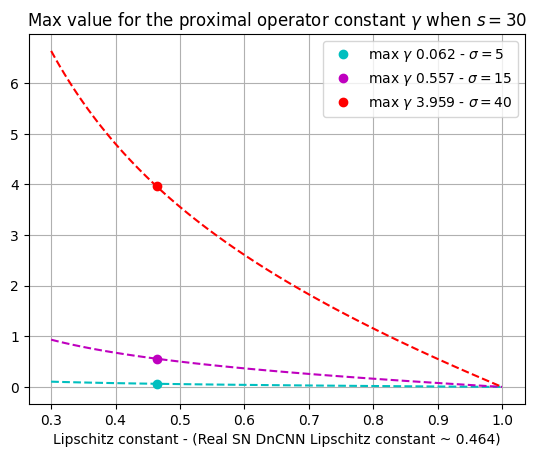

In [1]:
import matplotlib.pyplot as plt; import numpy as np
real_sn_dn_cnn_lipschitz = 0.464 # from the Ryu paper
lipschitz = np.linspace(0.3, 1, 100)
ratio = lambda l: (1+l-2*l**2)/l
s = 30
plt.xlabel('Lipschitz constant')
plt.title(f'Max value for the proximal operator constant $\gamma$ when $s={s}$')
colors = ['c', 'm', 'r' ]
for idx, sigma in enumerate([5, 15, 40]):
    noise_ratios = sigma**2/s**2
    max_ratio = noise_ratios*ratio(real_sn_dn_cnn_lipschitz)
    
    color = colors[idx]
    plt.plot(lipschitz, noise_ratios*ratio(lipschitz), color+"--")
    
    
    plt.plot(real_sn_dn_cnn_lipschitz, max_ratio, color+'o', label=f'max $\gamma$ {max_ratio:.3f} - $\sigma={sigma}$')
    plt.legend()
plt.xlabel(f'Lipschitz constant - (Real SN DnCNN Lipschitz constant ~ {real_sn_dn_cnn_lipschitz})')
plt.grid()
plt.show()


### Question 6
- When using DnCNN (without the Lipschitz constraint at training time), there are more visible local artifacts but the overall trend is similar to what we observed in question 5 for the `Real SN DnCNN`. See that bright spot on the nose for instance. This was discussed in question 3. already but here we see the limitations visually when the Lipschitz constraints where not taken into account at training time.

| Real SN-DnCNN $\sigma=15$ | DnCNN $\sigma=15$  |
|:---: | :--:|
| ![](figures/drs_real_dn_cnn_sigma=15.png) | ![](figures/drs_dnn_cnn_sigma=15.png) |


### Question 7

# Inpainting / Missing pixels

#### Question 8

##### Potential function
Notations: Random variables $Y, X, M, N$ (observation, unknown X,  known inpainting mask and noise).

For  a given observed pixel $y_{i}$ , $ y_i = m_i x_i + n_i$  where $m_i \sim \operatorname{Ber}(p)$ is known (**oracle on the inpainting mask**) and $n_i \sim \mathcal{N}(0,s^2)$ is additive white gaussian noise.


$\mathbb{p}_{Y|X} (Y=y_{i} | X=x_{i}) = \mathbb{p}_{Y|X} (Y=y_{i} | X=x_{i}, M={m_i}) = \mathbb{p}_{N}(N=y_i - m_i x_i) \propto e^{-\frac{(y_i - m_i x_i)^2}{2 s^2}}$ since the noise distribution of $N$ is Gaussian.

We assume that the noise is i.i.d so this formula stands for the whole imge considered as a vector (where the noise covariance matrix is a diagonal full of $\sigma^2$ and the mask matrix can also be expressed as a diagonal matrix $A$ filled with 0 and 1 ).

Potential for a single pixel:
$F(x_i, y_i) = \frac{1}{2 s^2}(m_i .x_i - y_i)^2$
which can be re-written for the whole matrix using vector notations.

$F(x, y) = \frac{1}{2 s^2}(A.x - y)^2$, note that the degradation operator $A$ is known. 


##### Proximal operator
Let's use a single pixel to avoid heavy pointless matrix computations here as all elements are independant.

$\text{prox}_{\alpha  F}(x) = \text{argmin}_v \frac{1}{2} \|v - x \|^2 + \alpha F(v) = \text{argmin}_v \frac{1}{2} (v - x)^2 + \alpha \frac{1}{2 s^2}(m.v - y)^2  $ .
- If $m=0$, $\text{prox}_{\alpha  F}(x)  =  x$
- If $m=1$, $\text{prox}_{\alpha  F}(x)$  can be found by zero-ing the derivate of function F. $\frac{df}{dx} = (v-x) + \frac{\alpha}{s^2} (v - y) = 0$ , $v=\frac{s^2 x+\alpha y}{s^2+\alpha}$

$$\text{prox}_{\alpha  F}(x) =\frac{s^2 x+\alpha y}{s^2+\alpha}$$



#### Cheatsheet
$\hat{x} = argmin F(x) + \lambda G(x) = \alpha * F(x) + \sigma^2 G(x)$

$\lambda = \frac{\sigma^2}{\alpha}$ , $\alpha<1$ to leave a bit of noise.

- $s$ actual standard deviation in $\tilde{u}$
- $\sigma$ noise standard deviation used to train the denoiser whose residual is considered as the poximal of $G$